## IF867 - Introdução à Aprendizagem Profunda
### 1ª atividade prática

Discente(s): Victor Amarante Florentino da Silva

Período: 2024.2

## Carregas bibliotecas necessárias

In [1]:
# --- analise e manipulacao de dados ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- machine learning e pre-processamento dos dados ---
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score

## Carregar datasets
1. iris dataset
2. wine quality dataset

In [2]:
# --- IRIS DATASET ---
iris_data = load_iris()
features, labels = iris_data.data, iris_data.target

binary_mask = labels != 2
features, labels = features[binary_mask], labels[binary_mask]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

labels = labels[:, np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

In [3]:
# --- WINE QUALITY DATASET ---
wine_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

X_reg = wine_data.iloc[:, :-1].values
y_reg = wine_data.iloc[:, -1].values[:, np.newaxis]

scaler_reg = StandardScaler()
X_reg = scaler_reg.fit_transform(X_reg)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

Agora que temos as bases de dados carregas, vamos implementar as funções de ativação que serão utilizadas dentro da classe de MLP para podermos criar a rede e, posteriormente, treiná-la.

## Funções de Ativação

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def linear(x):
    return x

def linear_derivative(x):
    return np.ones_like(x)

## Classe MLP

In [5]:
import numpy as np

class MLP:
    def __init__(self, layer_sizes, activations):
        self.layer_sizes = layer_sizes
        self.activations = activations
        self.weights = self._initialize_weights()

    def _initialize_weights(self):
        weights = {}
        np.random.seed(42)
        for i in range(1, len(self.layer_sizes)):
            weights[f'W{i}'] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i]) * np.sqrt(2 / self.layer_sizes[i-1])
            weights[f'b{i}'] = np.zeros((1, self.layer_sizes[i]))
        return weights

    def _activate(self, z, activation_func):
        activation_map = {
            'sigmoid': lambda z: 1 / (1 + np.exp(-z)),
            'relu': lambda z: np.maximum(0, z),
            'linear': lambda z: z
        }
        return activation_map.get(activation_func, lambda z: z)(z)

    def _activation_derivative(self, z, activation_func):
        derivative_map = {
            'sigmoid': lambda z: self._activate(z, 'sigmoid') * (1 - self._activate(z, 'sigmoid')),
            'relu': lambda z: (z > 0).astype(float),
            'linear': lambda z: np.ones_like(z)
        }
        return derivative_map.get(activation_func, lambda z: 1)(z)

    def _forward(self, X):
        cache = {'A0': X}
        A_prev = X
        for i in range(1, len(self.layer_sizes)):
            Z = np.dot(A_prev, self.weights[f'W{i}']) + self.weights[f'b{i}']
            A = self._activate(Z, self.activations[i-1])
            cache[f'Z{i}'] = Z
            cache[f'A{i}'] = A
            A_prev = A
        return cache[f'A{len(self.layer_sizes)-1}'], cache

    def compute_loss(self, Y_pred, Y, loss_type='mse'):
      if loss_type == 'mse':
          return np.mean((Y_pred - Y) ** 2)
      elif loss_type == 'bce':
          epsilon = 1e-10  # Para evitar log(0)
          Y_pred = np.clip(Y_pred, epsilon, 1 - epsilon)  # Garantir que as previsões estão entre 0 e 1
          return -np.mean(Y * np.log(Y_pred) + (1 - Y) * np.log(1 - Y_pred))
      return None


    def _backward(self, cache, Y, loss_type='mse'):
        m = Y.shape[0]
        A_final = cache[f'A{len(self.layer_sizes)-1}']

        # Calcular erro da camada de saída
        if loss_type == 'mse':
            dA = 2 * (A_final - Y) / m
        elif loss_type == 'bce':
            dA = -(Y / A_final) + ((1 - Y) / (1 - A_final))

        grads = {}
        for i in reversed(range(1, len(self.layer_sizes))):
            dZ = dA * self._activation_derivative(cache[f'Z{i}'], self.activations[i-1])
            A_prev = cache[f'A{i-1}']
            grads[f'dW{i}'] = np.dot(A_prev.T, dZ)
            grads[f'db{i}'] = np.sum(dZ, axis=0, keepdims=True)
            if i > 1:
                dA = np.dot(dZ, self.weights[f'W{i}'].T)
        return grads

    def _update_parameters(self, grads, learning_rate=0.01, momentum=0.9):
        if not hasattr(self, 'velocity'):
            self.velocity = {key: np.zeros_like(value) for key, value in self.weights.items()}

        for key in self.weights:
            self.velocity[key] = momentum * self.velocity[key] - learning_rate * grads[f'd{key}']
            self.weights[key] += self.velocity[key]

    def train(self, X, Y, iterations=1000, learning_rate=0.01, loss_type='mse', verbose=True):
        loss_history = []
        for iteration in range(iterations):
            Y_pred, cache = self._forward(X)
            loss = self.compute_loss(Y_pred, Y, loss_type)
            loss_history.append(loss)
            grads = self._backward(cache, Y, loss_type)
            self._update_parameters(grads, learning_rate)

            if verbose and (iteration % (iterations // 10) == 0 or iteration == iterations - 1):
                print(f"Iteração {iteration+1}/{iterations} - Perda: {loss:.4f}")
        return loss_history

    def predict(self, X):
        Y_pred, _ = self._forward(X)
        return Y_pred


Iteração 1/200 - Perda: 0.6737
Iteração 21/200 - Perda: 0.0046
Iteração 41/200 - Perda: 0.0011
Iteração 61/200 - Perda: 0.0008
Iteração 81/200 - Perda: 0.0007
Iteração 101/200 - Perda: 0.0007
Iteração 121/200 - Perda: 0.0007
Iteração 141/200 - Perda: 0.0006
Iteração 161/200 - Perda: 0.0006
Iteração 181/200 - Perda: 0.0006
Iteração 200/200 - Perda: 0.0005
acc train: 1.0
acc test: 1.0
f1 score test: 1.0000


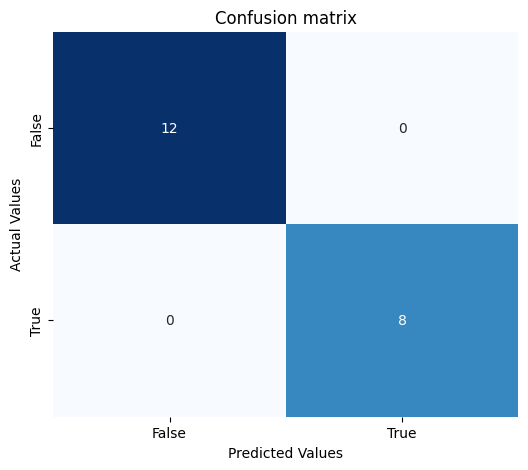

In [6]:
# Certifique-se de que y_train e y_test estão com a forma correta (coluna).
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Definindo a rede neural e funções de ativação
layer_sizes = [X_train.shape[1], 3, 3, 1]
activations = ['relu', 'sigmoid', 'sigmoid']

mlp_classifier = MLP(layer_sizes, activations)


loss_history = mlp_classifier.train(X_train, y_train, iterations=200, learning_rate=0.01, loss_type='bce')

y_pred_train = mlp_classifier.predict(X_train)
y_pred_train = (y_pred_train > 0.5).astype(int)

y_pred_test = mlp_classifier.predict(X_test)
y_pred_test = (y_pred_test > 0.5).astype(int)


train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print(f"acc train: {train_acc}")
print(f"acc test: {test_acc}")
print(f"f1 score test: {f1:.4f}")


cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['False', 'True'],
            yticklabels=['False', 'True'])

plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion matrix')

plt.show()

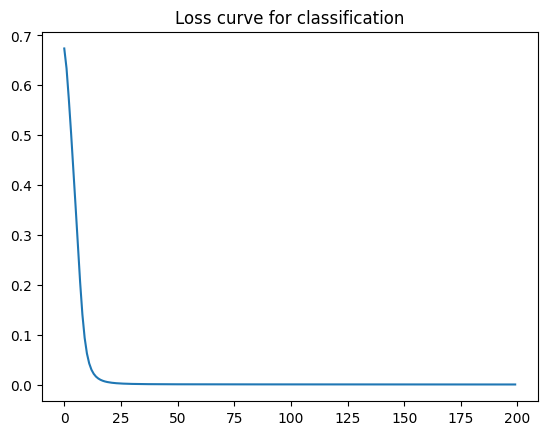

In [7]:
plt.plot(loss_history)
plt.title('Loss curve for classification')
plt.show()

Iteração 1/200 - Perda: 33.6609
Iteração 21/200 - Perda: 0.9616
Iteração 41/200 - Perda: 0.5397
Iteração 61/200 - Perda: 0.4784
Iteração 81/200 - Perda: 0.4563
Iteração 101/200 - Perda: 0.4464
Iteração 121/200 - Perda: 0.4414
Iteração 141/200 - Perda: 0.4374
Iteração 161/200 - Perda: 0.4331
Iteração 181/200 - Perda: 0.4289
Iteração 200/200 - Perda: 0.4260
mse train: 0.42583342336156266
mse test: 0.4127649606701807


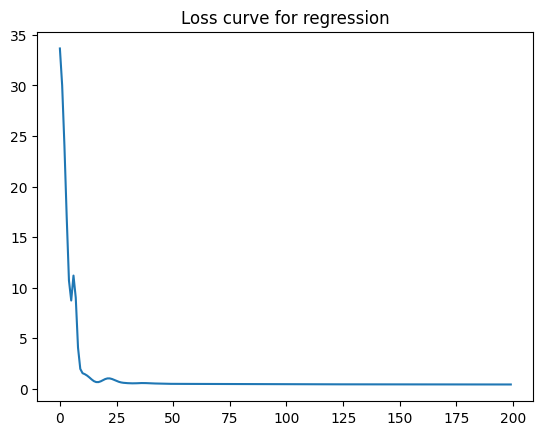

In [8]:
layer_sizes_reg = [X_train_reg.shape[1], 5, 8, 1]
activations_reg = ['relu', 'relu', 'linear']

mlp_regressor = MLP(layer_sizes_reg, activations_reg)

loss_history_reg = mlp_regressor.train(X_train_reg, y_train_reg, iterations=200, learning_rate=0.01, loss_type='mse')

y_pred_train_reg = mlp_regressor.predict(X_train_reg)
y_pred_test_reg = mlp_regressor.predict(X_test_reg)

mse_train = mean_squared_error(y_train_reg, y_pred_train_reg)
mse_test = mean_squared_error(y_test_reg, y_pred_test_reg)

print(f"mse train: {mse_train}")
print(f"mse test: {mse_test}")

plt.plot(loss_history_reg)
plt.title('Loss curve for regression')
plt.show()

/var/folders/3k/cb7k0ljx6nq3x52s0s1gh74c0000gn/T/ipykernel_50465/3012031945.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  plt.hist(activation.flatten(), bins=bins, alpha=0.5, label=f'camada {i}', color=plt.cm.get_cmap(colormap)(i / len(activations)))


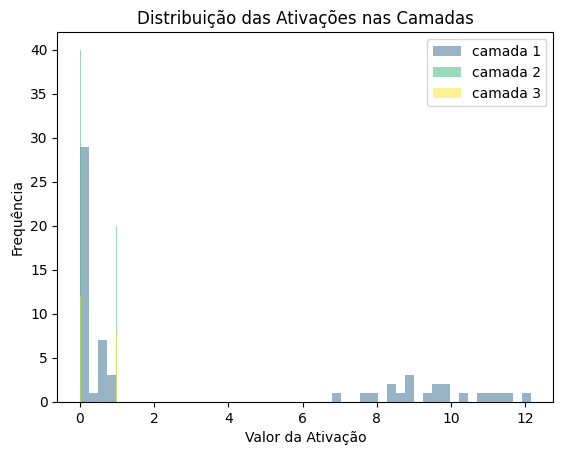

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_activations(model, X_sample, bins=30, num_examples=100, colormap='Blues'):
    # Propaga a entrada X_sample através da rede e obtém as ativações
    _, cache = model._forward(X_sample[:num_examples])

    # Coletando as ativações das camadas (de A1 até A_final)
    activations = [cache[f'A{i}'] for i in range(1, len(model.layer_sizes))]

    # Plotando as ativações
    for i, activation in enumerate(activations, 1):
        plt.hist(activation.flatten(), bins=bins, alpha=0.5, label=f'camada {i}', color=plt.cm.get_cmap(colormap)(i / len(activations)))

    plt.legend()
    plt.title('Distribuição das Ativações nas Camadas')
    plt.xlabel('Valor da Ativação')
    plt.ylabel('Frequência')
    plt.show()

# Alterando o número de exemplos e bins, e usando uma paleta de cores diferente
plot_activations(mlp_classifier, X_test, bins=50, num_examples=150, colormap='viridis')
